In [458]:
import csv

#Standard data-sci libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [459]:
#SKLearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesClassifier, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor, Lars, LassoLars,  ElasticNet, PassiveAggressiveRegressor, RANSACRegressor, SGDRegressor, TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn import metrics
from sklearn.svm import SVR

#XGBoost
import xgboost as xgb

In [460]:
#Dropping rows with outliers
def clean_outliers(df, col):
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    tolerance_threshold = 2
    low  = df[col].quantile(0.25) - tolerance_threshold*iqr
    high = df[col].quantile(0.75) + tolerance_threshold*iqr
    df_cleaned = df.loc[(df[col] > low) & (df[col] < high)]
    return df_cleaned

def rmse(a,b):
    return metrics.mean_squared_error(a,b)**0.5

In [461]:
train_data = ("../train_set.csv")
test_data = ("../test_set.csv")

train_rows = 100000
test_rows = 10 #In our case, we are not really using the test data for predictions, so keeping this number small.

In [462]:
#Train data
df = pd.read_csv(train_data, nrows=train_rows)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5d35c908>,
      dtype=object)

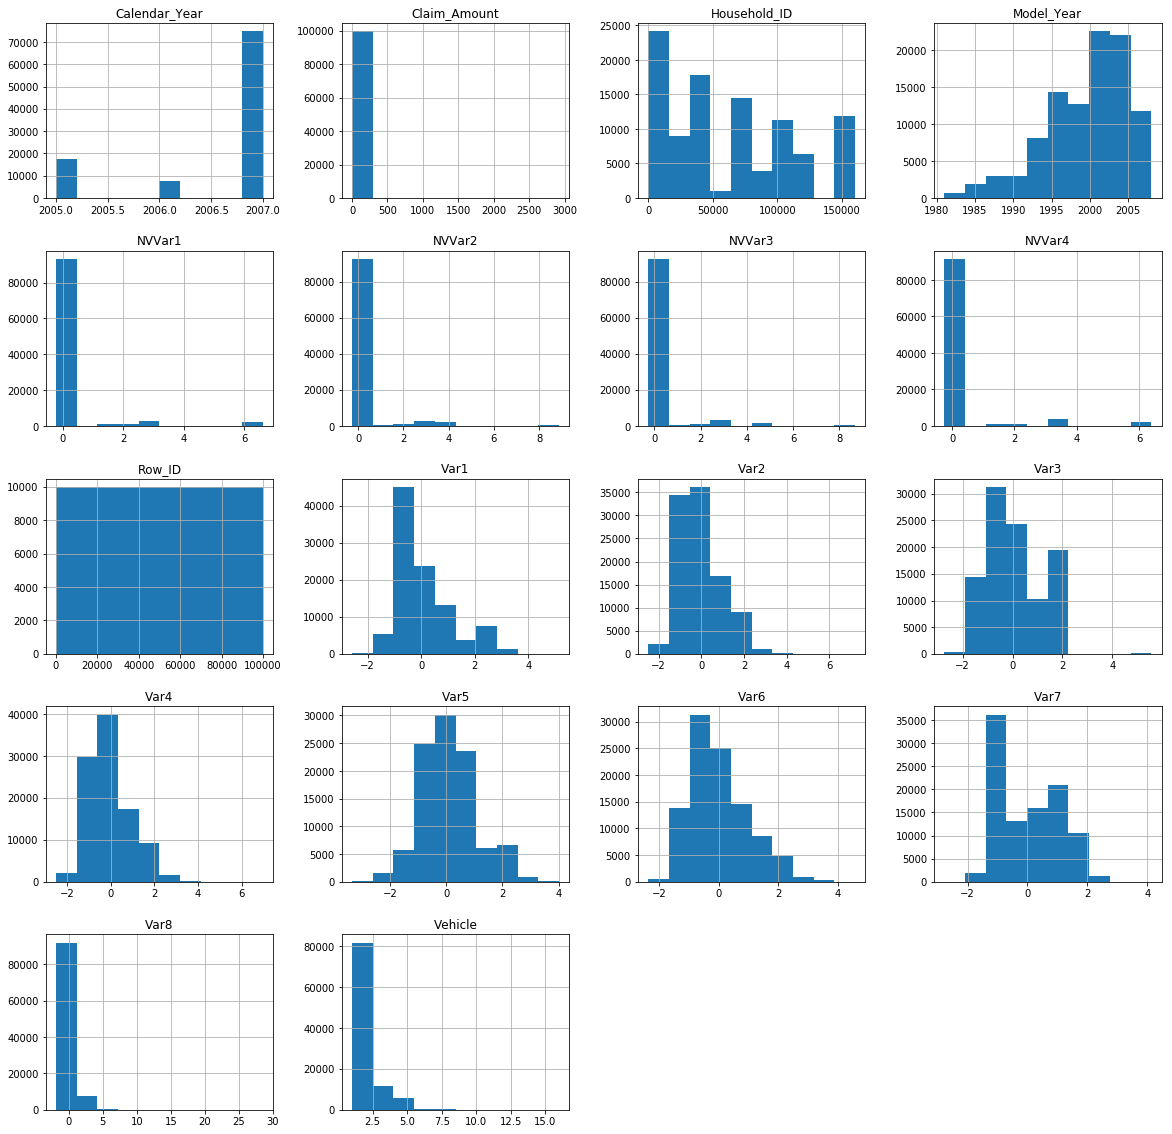

In [463]:
#Visualizing train data to gain intuition on the cleaning required

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20))

619
99381


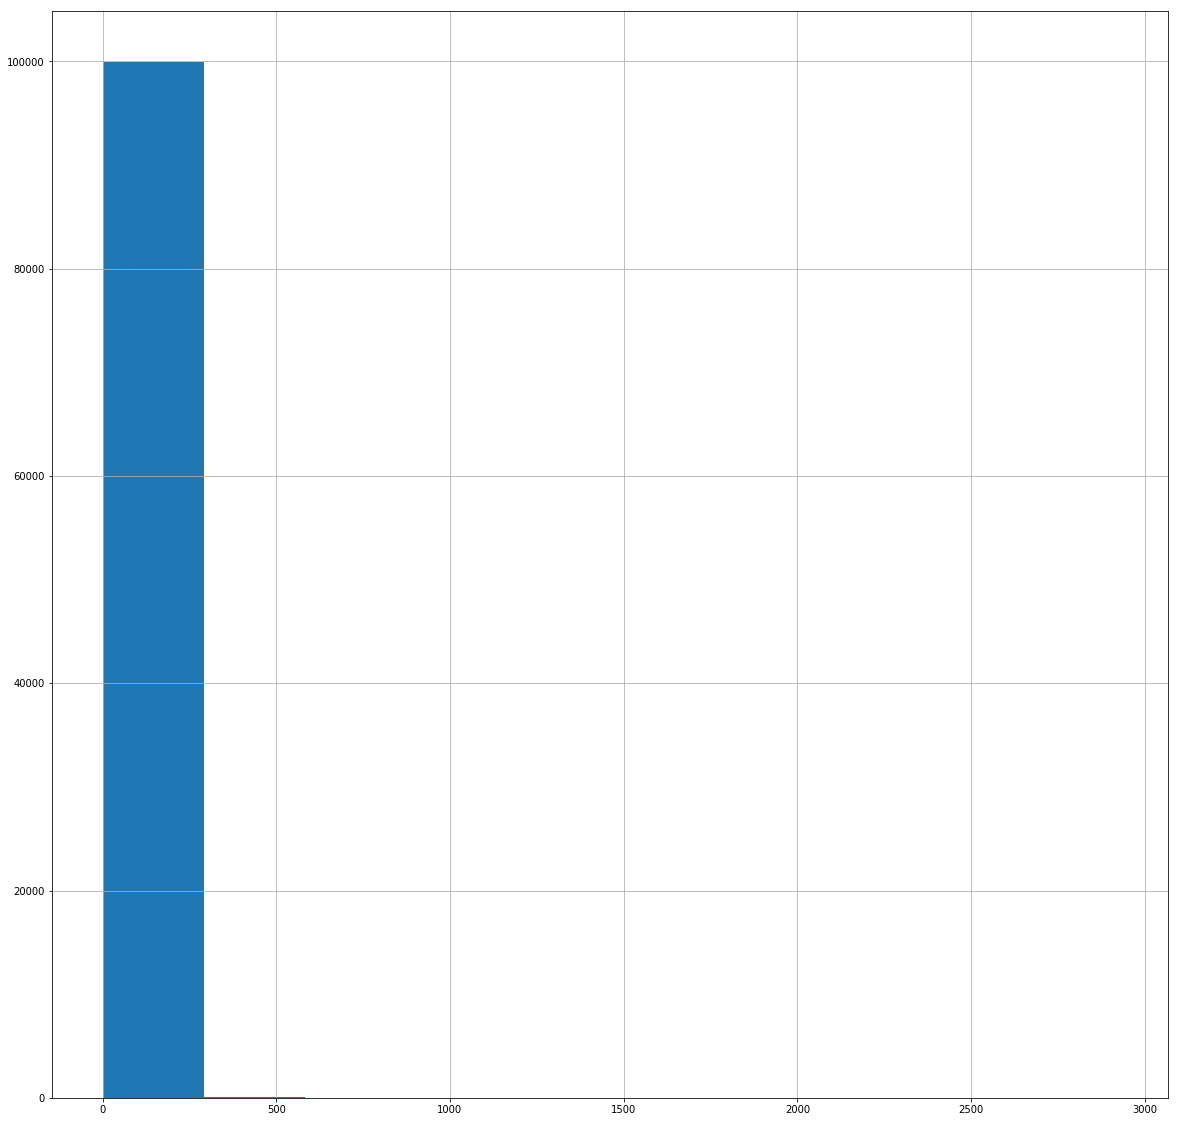

In [464]:
#Note from above that our data is highly imbalanced
print(df['Claim_Amount'][df['Claim_Amount']>0].shape[0])
print(df['Claim_Amount'][df['Claim_Amount']==0].shape[0])
df['Claim_Amount'].hist(figsize=(20,20))

In [465]:
#Balancing the data by oversampling:

df = df.append([df[df['Claim_Amount']>0]]*98, ignore_index=True)

61281
99381


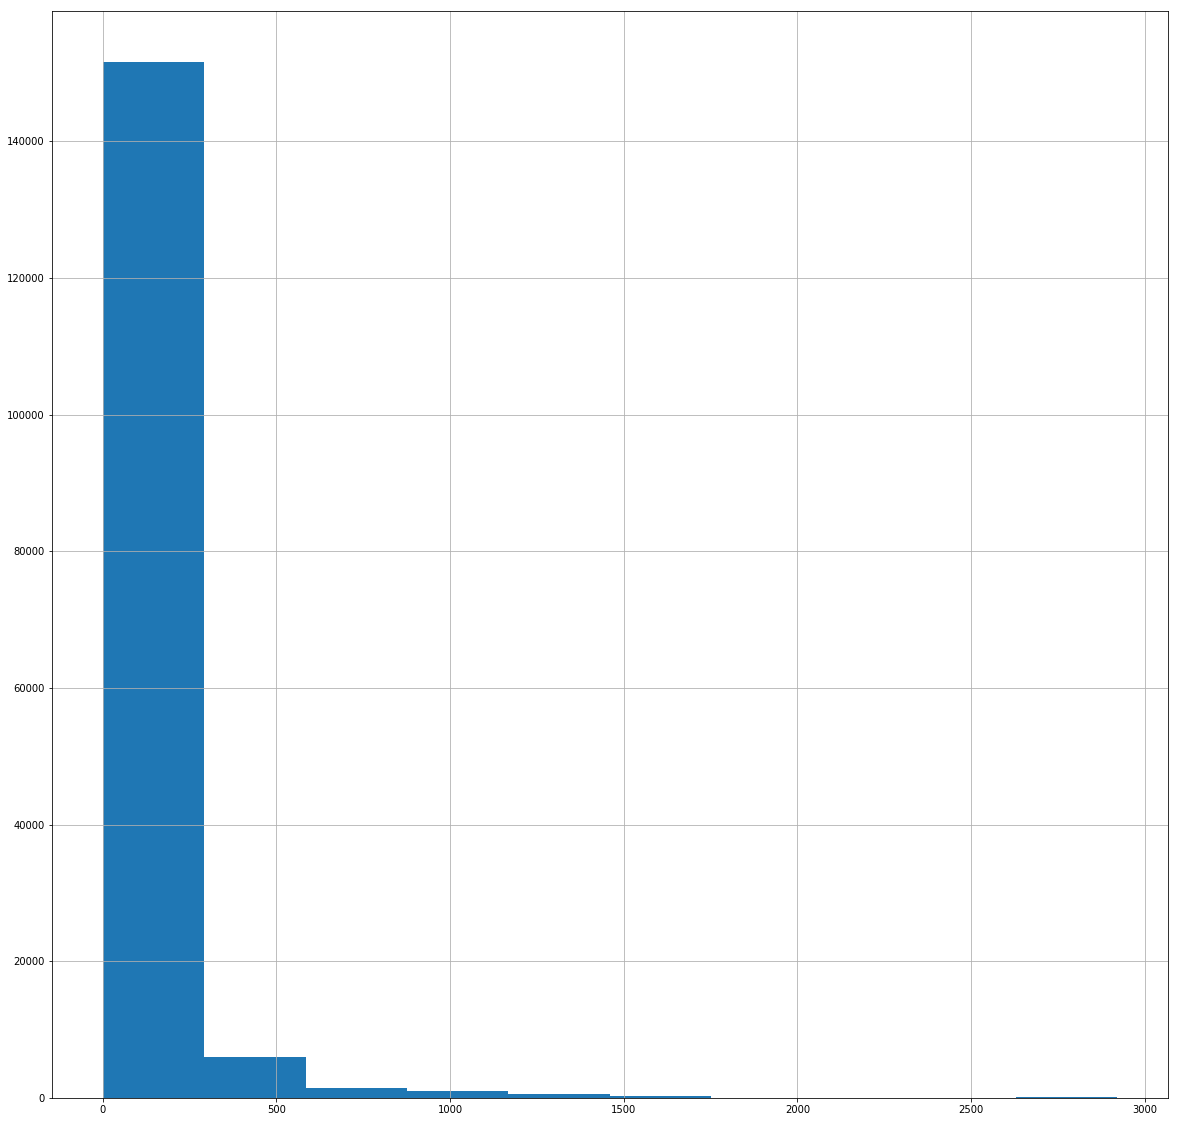

In [466]:
print(df['Claim_Amount'][df['Claim_Amount']>0].shape[0])
print(df['Claim_Amount'][df['Claim_Amount']==0].shape[0])
df['Claim_Amount'].hist(figsize=(20,20))

In [467]:
#cleaning train data

#remove columns with more than a certain proprotion of missing values
missing_value_proportion = 0.75
df = df[df.columns[df.isnull().mean() < missing_value_proportion]]
df = df.loc[df.isnull().mean(axis=1) < missing_value_proportion]

#drop rows with NaNs
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#replace booleans with ints
df.replace({False: 0, True: 1}, inplace=True)

In [468]:
#Test data
test_df = pd.read_csv(test_data, nrows=test_rows)

In [469]:
#Further cleaning training and testing data

#dropping columns with no predictive information
df.drop(columns=['Row_ID'], inplace=True)
test_df.drop(columns=['Row_ID'], inplace=True)

In [470]:
#missing preprocessing block
#replace "?" with column mode
df.replace("?", np.NaN, inplace=True)
categorical_columns = ['Cat' + str(i) for i in range(1,13)]
categorical_columns += ['Blind_Make','Blind_Model','Blind_Submodel','NVCat']

for categorical_column in categorical_columns:
    df[categorical_column].fillna(df[categorical_column].mode()[0], inplace=True)
    
df.dropna(inplace=True)

In [ ]:
#Getting categorical variables split up in training data
for categorical_column in categorical_columns:
    dummied_cols= df[categorical_column].str.get_dummies()
    dummied_cols.columns = [categorical_column + '_' + str(col) for col in dummied_cols.columns]
    df = pd.concat([df, dummied_cols], axis = 1)

df.drop(columns=categorical_columns, inplace=True)

#Getting categorical variables split up in testung data
for categorical_column in categorical_columns:
    dummied_cols= test_df[categorical_column].str.get_dummies()
    dummied_cols.columns = [categorical_column + '_' + str(col) for col in dummied_cols.columns]
    test_df = pd.concat([test_df, dummied_cols], axis = 1)

test_df.drop(columns=categorical_columns, inplace=True)

In [ ]:
preprocessed_df = df
preprocessed_test_df = test_df

preprocessed_df.describe()

In [ ]:
train_x = preprocessed_df.drop(['Claim_Amount'], axis=1)
train_y = preprocessed_df['Claim_Amount']
test_x = preprocessed_test_df

In [ ]:
#Aligning features in training and testing

test_features = test_x.columns.tolist()
for train_feature in train_x.columns.tolist():
    if train_feature not in test_features:
        test_x[train_feature] = 0

train_features = train_x.columns.tolist()
for test_feature in test_x.columns.tolist():
    if test_feature not in train_features:
        test_x.drop(columns=[test_feature],inplace=True)

In [ ]:
test_x.fillna(test_x.median(), inplace=True)

In [ ]:
print(train_x.shape,test_x.shape,train_y.shape)

In [ ]:
# Splitting the dataset

X_train, X_test, Y_train, Y_test = train_test_split(train_x,train_y, test_size=0.2,random_state=0)

In [ ]:
print(X_train.shape,X_test.shape,Y_test.shape,Y_train.shape)


In [434]:
mm_scaler = MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.fit_transform(X_test)

/Users/Talha/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/Talha/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [435]:
def allmodels():
    classifiers = [
    AdaBoostRegressor(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    PassiveAggressiveRegressor(),
    #SGDRegressor(),
    #TheilSenRegressor(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    ExtraTreeRegressor()
]
    names = [
    "AdaBoostRegressor",
    "BaggingRegressor",
    "ExtraTreesRegressor",
    "GradientBoostingRegressor",
    "RandomForestRegressor",
    "PassiveAggressiveRegressor",
    #"SGDRegressor",
    #"TheilSenRegressor",
    "KNeighborsRegressor",
    "DecisionTreeRegressor",
    "ExtraTreeRegressor"
]
    return classifiers,names
classifiers,names=allmodels()

In [436]:
iterations=1
for i in range(iterations):  
    result=[]
    for classifier,name in zip(classifiers,names):
        classifier.fit(X_train, Y_train)
        predictions=classifier.predict(X_test)
        predictions[predictions<0]=0
        result.append(rmse(predictions,Y_test))
    model_result=pd.DataFrame(data=result,index=names,columns=['rmse']).sort_values(by="rmse" , ascending=True)
    print(model_result)

/Users/Talha/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Talha/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Talha/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


                                rmse
ExtraTreeRegressor          1.266730
GradientBoostingRegressor   2.324986
ExtraTreesRegressor         2.481977
BaggingRegressor            2.537841
RandomForestRegressor       2.648898
AdaBoostRegressor           3.022570
KNeighborsRegressor         4.078622
DecisionTreeRegressor       4.697133
PassiveAggressiveRegressor  4.741581


/Users/Talha/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


                                rmse
ExtraTreeRegressor          1.216377
DecisionTreeRegressor       1.229092
ExtraTreesRegressor         1.372336
GradientBoostingRegressor   2.313402
AdaBoostRegressor           2.581139
RandomForestRegressor       2.592832
BaggingRegressor            3.325438
KNeighborsRegressor         4.078622
PassiveAggressiveRegressor  4.754934


In [437]:
xgboost_model = xgb.XGBRegressor(learning_rate=0.05
                                 , max_depth=12, n_estimators=10, alpha=10, objective ='reg:linear', colsample_bytree = 0.3
                                )
xgboost_model.fit(X_train,Y_train)
y_pred = xgboost_model.predict(X_test)
print('rmse',metrics.mean_squared_error(Y_test,y_pred)**0.5)

/Users/Talha/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:35:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse 15.69774364848571


In [439]:
#Let's try an RFR with optimized depth and estimator parameters
def rfr_model(X, y, max_depth_gsc):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3, max_depth_gsc),
            'n_estimators': (10, 50, 100, 200, 500),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],
                                random_state=False, verbose=False, max_features="sqrt")

    rfr.fit(X, y)

    return rfr

In [441]:
max_depth_gsc = 25

rfr = rfr_model(X_train, Y_train, max_depth_gsc)
predictions = rfr.predict(X_test)
predictions[predictions<0]=0
print(rmse(predictions,Y_test))

/Users/Talha/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


7.042936474707537
